# Varying effects, priors for correlations, and Cholesky factors

Covariance priors for multivariate normal models are an important tool for the implementation of varying effects. By representing more than one parameter with a covarying structure, even more partial pooling can result than if the parameters had their own separate distribution. However, parameterization strategies with covariance priors must be considered for MCMC sampling to proceed efficiently.

While working through Statistical Rethinking problems in `pymc`, some of the output confused me. I had to slow down to make sure I was doing non-centered paramaterizations correctly. Evaluating concepts more deeply helped me understand connections between covariance and non-covariance priors. Here, I'll talk about what I learned.

Shout out to these sources:
- [2022 Statistical Rethinking lecture 14 from Richard McElreath](https://www.youtube.com/watch?v=XDoAglqd7ss&list=PLDcUM9US4XdMROZ57-OIRtIK0aOynbgZN&index=14)
- [The Statistical Rethinking Chapter 14 PyMC repo](https://github.com/pymc-devs/resources/blob/master/Rethinking/Chp_14.ipynb)
- [PyMC documentation on covariance priors](https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/LKJ.html)


In [2]:
import arviz as az
from matplotlib.patches import Ellipse, transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as stats
from scipy.special import expit, logit
import seaborn as sns

In [5]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

I used Dr. McElreath's example of cafe waiting times and modified them for this demonstration. In his description of the problem in Chapter 14, the waiting time of a cafe is paramaterized by $\mu$ which is a result of the average morning waiting time (the intercept $\alpha$) plus the difference between morning and afternoon (the slope $\beta$). I'll give this problem a twist: let's say we're not trying to predict waiting time, but hiring another employee which is influenced by a cafe's waiting time. The longer the waiting time, the more likely a cafe would hire an additional worker. This means we'll use a Bernoulli/Binomial GLM.

This will be our scenario for comparing different parameterizations with different kinds of varying effects models. One varying effects model will be varying intercepts (where we only have morning wait times) and another will have information pooled across intercepts and slopes (a co-varying model that utilizes both morning and afternoon wait times). To summarize, we'll have four models:
1. centered parameterization, varying intercepts
2. centered parameterization, co-varying intercepts and slopes
3. non-centered parameterization, varying intercepts
4. non-centered parameterization, co-varying intercepts and slopes

# Centered paramaterizations

We can look directly at the equations side-by-side to see how the parameters between varying intercepts and varying effects compare.

<center>

**Centered paramaterization**  

|  | varying intercepts | varying effects|
| -- | -- | -- | 
| likelihood | $ H_i \sim \text{Bernoulli}(p_i) $  | $ H_i \sim \text{Bernoulli}(p_i) $  |
| linear model | $ \text{logit}(p_i) = \alpha_{\text{cafe}[i]} $  | $ \text{logit}(p_i) = \alpha_{\text{cafe}[i]} + \beta_{\text{cafe}[i]}A_i $  |
| adaptive prior for each cafe | $ \alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma_{\alpha}) $  | $ \begin{bmatrix}\alpha_j \\ \beta_j \end{bmatrix} \sim \text{MVNormal} \left( \begin{bmatrix}\bar{\alpha} \\ \bar{\beta} \end{bmatrix} , \bold{\Sigma} \right)  $  | 
| hyperprior for average cafe | $ \bar{\alpha} \sim \text{Normal}(0, 1.5) $  | $ \bar{\alpha}, \bar{\beta} \sim \text{Normal}(0, 1.5) $   |
| hyperprior for SD of cafe | $ \sigma_{\alpha} \sim \text{Exp}(1) $  | $ \sigma_{\alpha}, \sigma_{\beta} \sim \text{Exp}(1) $   |
| hyperprior for correlation matrix | n/a | $ \text{LKJCorr}(2) $   |

</center>

While I've displayed the differences in this table side-by-side to make it easy to compare, I'd like to draw your attention first to the line describing adaptive priors. In particular, the varying intercepts model uses a univariate Normal prior for $\alpha$. In a varying effects model, we could create a separate Normal prior for $\beta$, but by using a multivariate Normal that contains *both* $\alpha$ and $\beta$, we increase our ability to partial pool. The difference between the varying intercepts and varying effects for the variance parameter of the adaptive prior is also worth pointing out. The varying intercepts case only needs one $\sigma$ parameter. The varying effects model uses $\Sigma$ (capital sigma) where the variance for $\alpha$ and $\beta$ are in a single covariance matrix.

## Generative model

As I've written about [before](https://benslack19.github.io/data%20science/statistics/stats_rethinking_ch03_sim4blog_part1/), running models forward with a generative simulation before running it backwards helps facilitate understanding. This seems trivial but paying attention to the dimensions of each variable and whether the relationship to the right side is deterministic (= sign) or stochastic (~ sign) was helpful. I'll bring up these points later. Let's start with the varying intercepts model.

### Varying intercepts

We can generate data two ways. In the first way, we input arbitrary values that would feed directly into values for $\alpha_j$. Here, we would assign values to $\bar{\alpha}$ and $\sigma_{\alpha}$ which paramaterizes the Normal distribution for each cafe. We can then draw samples to produce a hypothetical mean waiting time for a cafe. (Note that while this command can be vectorized, I'll write it as a loop here to make the steps clearer.)

In [6]:
N_cafe = 20         # number of cafes
sigma_a = 1.0  # std dev in intercepts
a_bar = 3.5    # average morning wait time

a_cafes = np.zeros((N_cafe, 1))
for i in range(N_cafe):
    a = stats.norm.rvs(loc=a_bar, scale=sigma_a, size=1)
    a_cafes[i] = a

<IPython.core.display.Javascript object>

In [7]:
a_cafes

array([[3.20856787],
       [2.22966919],
       [4.41979879],
       [5.79447325],
       [3.161021  ],
       [2.12235193],
       [5.67794384],
       [1.36745876],
       [3.95146367],
       [3.6294516 ],
       [3.17051385],
       [3.1102896 ],
       [5.46706129],
       [4.28099003],
       [3.56009008],
       [3.43950003],
       [3.14521987],
       [4.173507  ],
       [3.58672537],
       [3.70135155]])

<IPython.core.display.Javascript object>

Next, we're going to simulate observations or visit the cafe several times. To make things interesting, let's make the data unbalanced to better appreciate the partial pooling effect. Later, we'd expect those cafes with a small number of observations to be most affected. (In the following code, I get a variable distribution of number of visits by playing with parameters of a beta-binomial distribution and tested different random seeds such that I would have at least one visit for each cafe.)

[Text(0.5, 0, 'cafe'),
 Text(0, 0.5, 'no. of visits'),
 Text(0.5, 1.0, 'No. of visits to each cafe')]

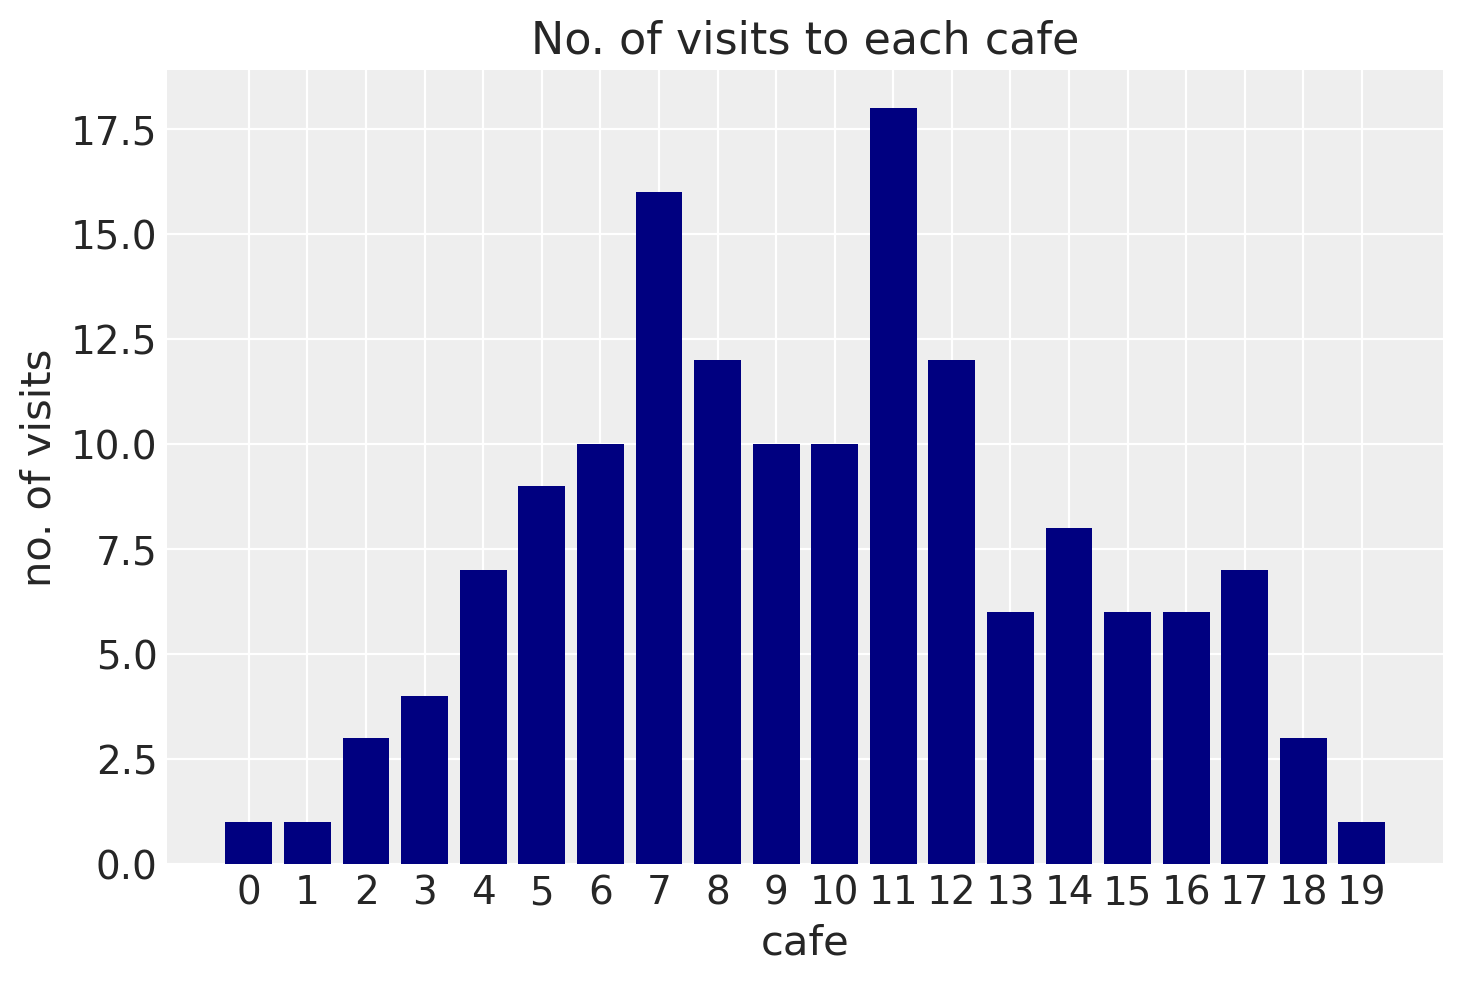

<IPython.core.display.Javascript object>

In [19]:
n_visits_total = 150
n_visits2cafe = pd.Series(stats.betabinom(n=19, a=3, b=3).rvs(size=n_visits_total, random_state=2)).value_counts().sort_index()

f, ax0 = plt.subplots()
ax0.bar(n_visits2cafe.index, n_visits2cafe, color='navy')
ax0.set_xticks(n_visits2cafe.index)
ax0.set_xticklabels(n_visits2cafe.index)
ax0.set(xlabel='cafe', ylabel='no. of visits', title='No. of visits to each cafe')

Now, we'll create a new dataframe with observations that reflect the variables we've created. First, I want to take a step back and highlight the different levels we're evaluating. The variables created above (`a_bar` and `sigma_a`) represent the *population* of cafes. However, each cafe has its *own* average weight time. Each cafe's average weight time is the vector we created with `a_cafe`. But each cafe has its own variance in weight time. That is what we create to have a variable number of observations to complete our dataframe. In theory, we can make this also vary between cafes. For simplicity, let's assume that each cafe has the same variance in wait time within itself. I'll represent this with `sigma_within` and set it to 0.5

In [9]:
n_visits2cafe

0      1
1      1
2      3
3      4
4      7
5      9
6     10
7     16
8     12
9     10
10    10
11    18
12    12
13     6
14     8
15     6
16     6
17     7
18     3
19     1
dtype: int64

<IPython.core.display.Javascript object>

In [11]:
sigma_within = 0.5

cafe_visits = list()
wait_obs = list()
for i in range(N_cafe):
    cafe_visit = [i] * n_visits2cafe[i]
    cafe_visits += cafe_visit
    a4cafe = stats.norm.rvs(loc=a_cafes[i], scale=sigma_within, size=n_visits2cafe[i])
    wait_obs += list(a4cafe)

# standardize across all observations and cafes
wait_time_std = standardize(wait_obs)

df_cafes = pd.DataFrame(
    {"cafe":cafe_visits,
     "wait":wait_obs,
     "wait_time_std":wait_time_std
    }
)

df_cafes.head(10)

,cafe,wait,wait_time_std
0,0,3.661337,0.089422
1,1,1.909557,-1.230624
2,2,4.302882,0.572856
3,2,4.262639,0.542531
4,2,4.743888,0.905174
5,3,5.853217,1.741104
6,3,5.998645,1.850691
7,3,5.653138,1.590336
8,3,5.481890,1.461292
9,4,3.470327,-0.054513


<IPython.core.display.Javascript object>

Okay so now we have our generated data of 150 wait times for cafe visits spread (unevenly) across 20 different cafes. Which orders are flagged for taking too long to create?

In [14]:
# df_cafes_summary = df_cafes.groupby('cafe').mean()
# df_cafes_summary['prob_hire'] = expit(df_cafes_summary['wait_time_std'])
# df_cafes_summary['cafe_hire'] = df_cafes_summary['prob_hire'] > 0.5
# df_cafes_summary['n_visits'] = df_cafes.groupby('cafe').size()
# df_cafes_summary.reset_index(inplace=True)
# df_cafes_summary


<IPython.core.display.Javascript object>

In [16]:
df_cafes['prob_flag_order'] = expit(df_cafes['wait_time_std'])
df_cafes['flagged_order'] = (df_cafes['prob_flag_order'] > 0.5).astype(int)
df_cafes.head(10)

,cafe,wait,wait_time_std,prob_flag_order,flagged_order
0,0,3.661337,0.089422,0.522341,1
1,1,1.909557,-1.230624,0.226072,0
2,2,4.302882,0.572856,0.639422,1
3,2,4.262639,0.542531,0.632401,1
4,2,4.743888,0.905174,0.712012,1
5,3,5.853217,1.741104,0.850827,1
6,3,5.998645,1.850691,0.864208,1
7,3,5.653138,1.590336,0.830663,1
8,3,5.481890,1.461292,0.811730,1
9,4,3.470327,-0.054513,0.486375,0


<IPython.core.display.Javascript object>

,cafe,wait,wait_time_std,prob_flag_order,flagged_order
0,0,3.661337,0.089422,0.522341,1
1,1,1.909557,-1.230624,0.226072,0
2,2,4.302882,0.572856,0.639422,1
3,2,4.262639,0.542531,0.632401,1
4,2,4.743888,0.905174,0.712012,1
...,...,...,...,...,...
145,17,4.287323,0.561132,0.636714,1
146,18,2.819290,-0.545099,0.367002,0
147,18,3.376352,-0.125327,0.468709,0
148,18,3.717057,0.131410,0.532805,1


<IPython.core.display.Javascript object>

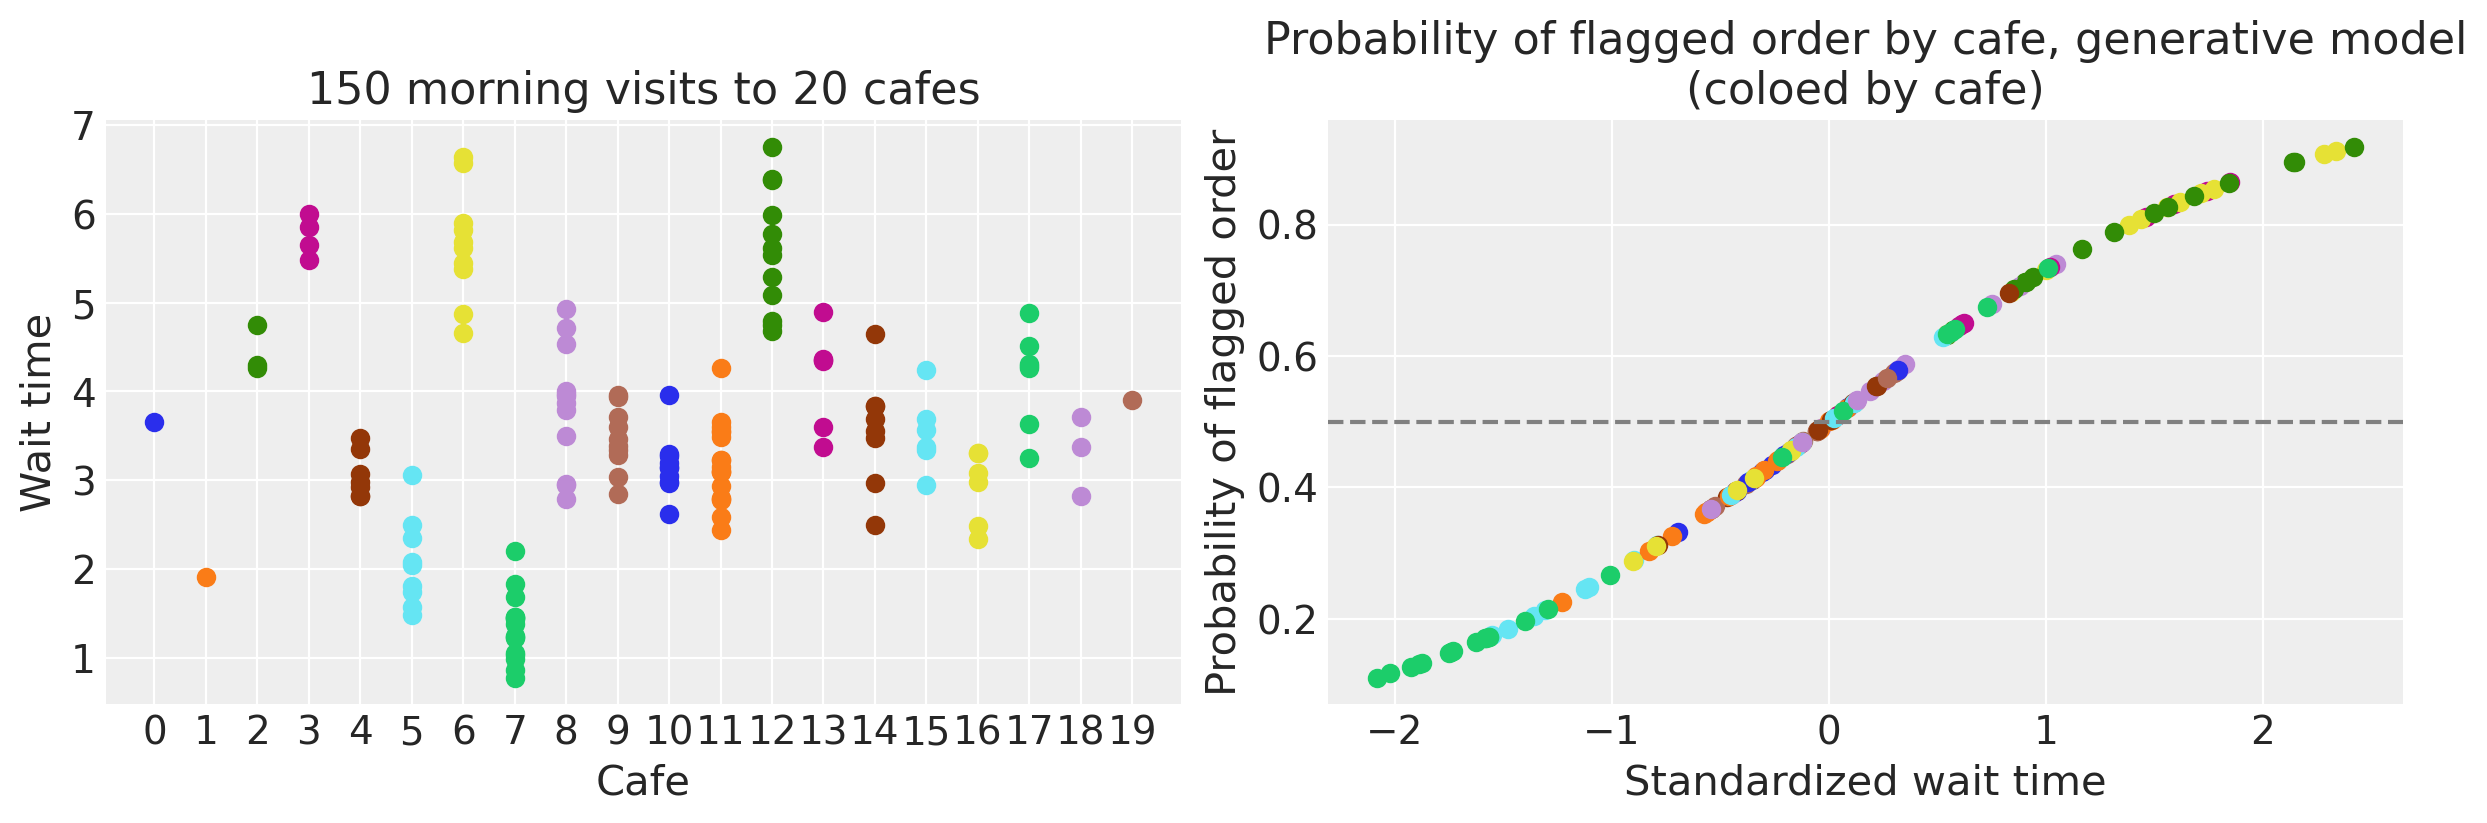

<IPython.core.display.Javascript object>

In [31]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,4))
# plot a different color for each cafe
for cafe in range(N_cafe):
    df_cafe = df_cafes[df_cafes['cafe'] == cafe].copy()
    ax0.scatter(df_cafe['cafe'], df_cafe['wait'])
    df_cafe_summary = df_cafe[df_cafe['cafe'] == cafe].copy()
    ax1.scatter(df_cafe['wait_time_std'], df_cafe['prob_flag_order'])
    
ax0.set(
    xlabel='Cafe',
    ylabel='Wait time',
    title=f'{n_visits_total} morning visits to {N_cafe} cafes',
    xticks=(range(N_cafe)),
    xticklabels=(range(N_cafe))
)

ax1.axhline(0.5, color='gray', linestyle='--')
ax1.set(
    xlabel='Standardized wait time',
    ylabel='Probability of flagged order',
    title='Probability of flagged order by cafe, generative model\n(coloed by cafe)'
    );

In [32]:
df_cafes

,cafe,wait,wait_time_std,prob_flag_order,flagged_order
0,0,3.661337,0.089422,0.522341,1
1,1,1.909557,-1.230624,0.226072,0
2,2,4.302882,0.572856,0.639422,1
3,2,4.262639,0.542531,0.632401,1
4,2,4.743888,0.905174,0.712012,1
...,...,...,...,...,...
145,17,4.287323,0.561132,0.636714,1
146,18,2.819290,-0.545099,0.367002,0
147,18,3.376352,-0.125327,0.468709,0
148,18,3.717057,0.131410,0.532805,1


<IPython.core.display.Javascript object>

In [48]:
wait_time_std = df_cafes['wait_time_std'].values
cafe_idx = df_cafes['cafe'].values

with pm.Model() as mVIc:

    # prior for average cafe wait time
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    # prior for SD of cafe wait time
    sigma_a = pm.Exponential("sigma_a", 1.0)

    # alpha priors for each cafe wait time
    a = pm.Normal("a", a_bar, sigma_a, shape=N_cafe)

    # link function
    p = pm.Deterministic("p", pm.math.invlogit(a[cafe_idx]))

    # likelihood, n=1 since each represents an individual cafe visit
    h = pm.Bernoulli("h", p=p, observed=df_cafes["flagged_order"])

    idata_mVIc = pm.sample(draws=1000, progressbar=False)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_bar, sigma_a, a]
INFO:pymc:NUTS: [a_bar, sigma_a, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


<IPython.core.display.Javascript object>

In [49]:
az.summary(idata_mVIc, var_names='a')

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],2.095,2.364,-1.607,5.479,0.043,0.041,3726.0,2553.0,1.0
a[1],-1.955,2.280,-5.316,1.689,0.039,0.036,4050.0,2581.0,1.0
a[2],2.961,2.025,-0.134,5.658,0.043,0.037,3028.0,1874.0,1.0
a[3],3.179,1.927,0.128,5.839,0.038,0.031,3216.0,1997.0,1.0
a[4],-3.562,1.842,-5.933,-0.681,0.037,0.030,3399.0,1998.0,1.0
a[5],-3.746,1.780,-6.204,-1.088,0.037,0.029,2893.0,2119.0,1.0
a[6],3.826,1.747,1.096,6.218,0.036,0.027,2795.0,2293.0,1.0
a[7],-4.205,1.728,-6.418,-1.593,0.036,0.028,3051.0,2194.0,1.0
a[8],0.705,0.621,-0.308,1.657,0.008,0.008,5534.0,3110.0,1.0
a[9],-0.405,0.659,-1.373,0.713,0.009,0.009,5325.0,2841.0,1.0


<IPython.core.display.Javascript object>

In [42]:
expit(df_cafes.groupby('cafe').mean()['wait_time_std'])

cafe
0     0.522341
1     0.226072
2     0.662291
3     0.840353
4     0.410455
5     0.248121
6     0.831183
7     0.158986
8     0.553868
9     0.483797
10    0.428920
11    0.432798
12    0.823471
13    0.613269
14    0.503881
15    0.497146
16    0.384572
17    0.614869
18    0.455202
19    0.566603
Name: wait_time_std, dtype: float64

<IPython.core.display.Javascript object>

In [39]:
expit(az.summary(trace_mVIc, var_names='a')['mean'])

a[0]     0.887054
a[1]     0.115373
a[2]     0.951200
a[3]     0.962529
a[4]     0.024747
a[5]     0.021269
a[6]     0.980392
a[7]     0.014064
a[8]     0.672827
a[9]     0.397714
a[10]    0.098767
a[11]    0.276478
a[12]    0.982690
a[13]    0.836307
a[14]    0.626212
a[15]    0.497750
a[16]    0.029656
a[17]    0.865413
a[18]    0.324318
a[19]    0.891871
Name: mean, dtype: float64

<IPython.core.display.Javascript object>

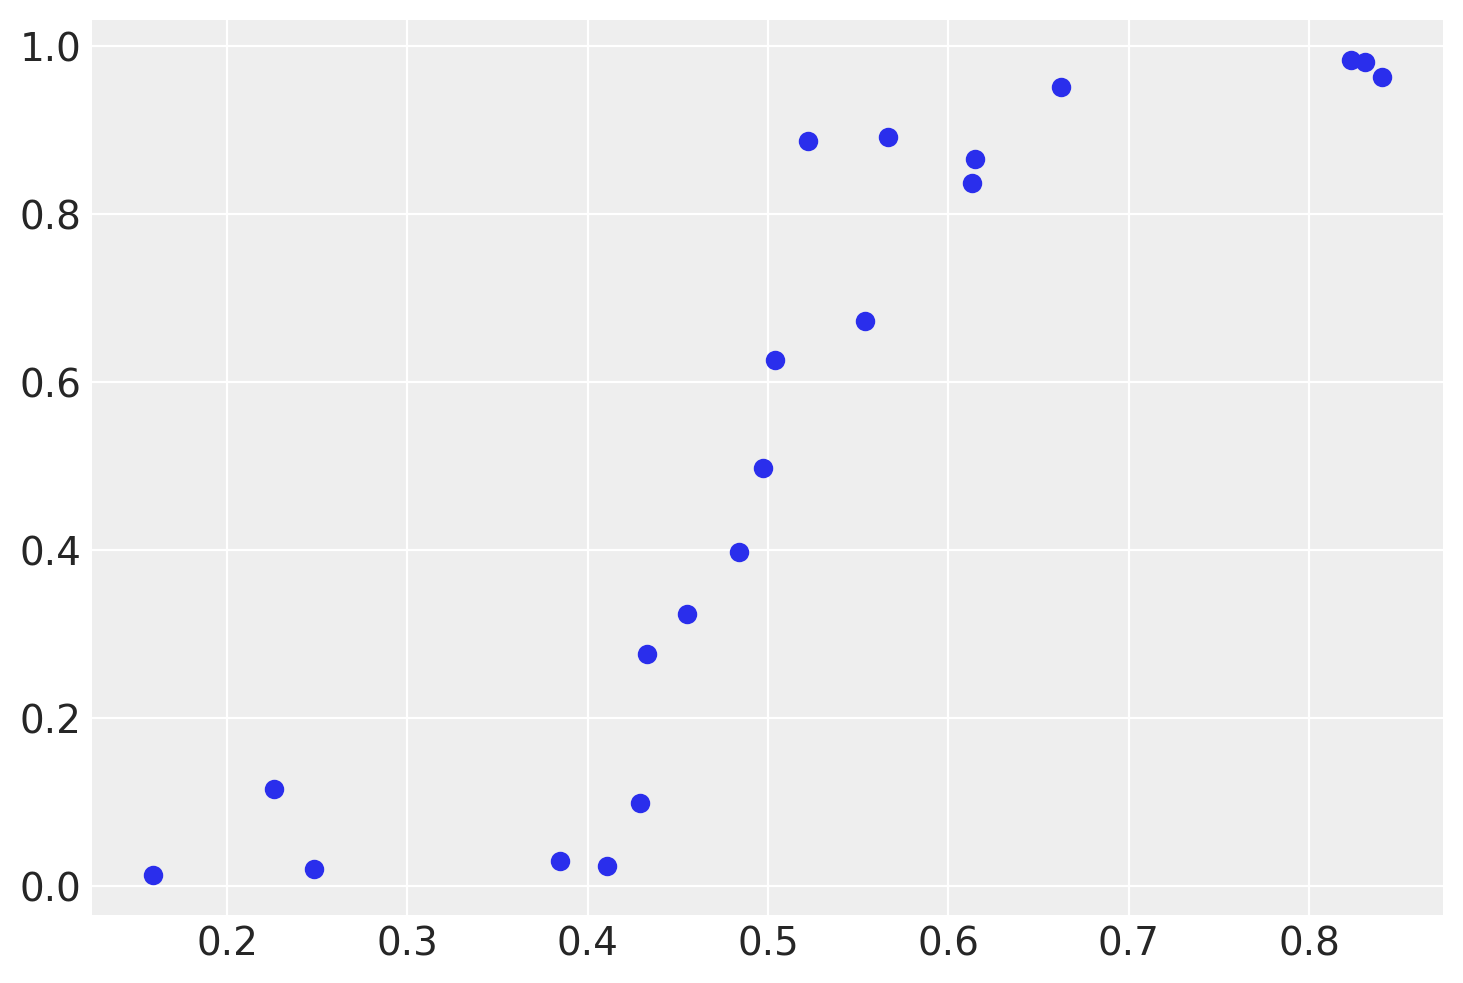

<IPython.core.display.Javascript object>

In [43]:
plt.scatter(
    expit(df_cafes.groupby('cafe').mean()['wait_time_std']),
    expit(az.summary(trace_mVIc, var_names='a')['mean'])
)

In [47]:
az.summary(trace_mVIc, var_names=['a', 'a_bar', 'sigma_a'])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],2.068,2.371,-1.441,5.623,0.040,0.040,4537.0,2180.0,1.0
a[1],-1.986,2.308,-5.430,1.564,0.045,0.040,3101.0,1965.0,1.0
a[2],2.951,2.043,-0.059,5.835,0.042,0.035,3221.0,1879.0,1.0
a[3],3.123,1.893,0.431,5.920,0.039,0.031,3135.0,2186.0,1.0
a[4],-3.515,1.803,-6.197,-0.920,0.038,0.030,2775.0,1972.0,1.0
a[5],-3.757,1.823,-6.087,-0.962,0.037,0.029,2995.0,2065.0,1.0
a[6],3.936,1.937,1.186,6.624,0.042,0.034,3023.0,1760.0,1.0
a[7],-4.205,1.758,-6.477,-1.568,0.041,0.031,2423.0,1685.0,1.0
a[8],0.717,0.627,-0.285,1.688,0.009,0.008,5499.0,3186.0,1.0
a[9],-0.419,0.651,-1.411,0.635,0.009,0.009,4911.0,2664.0,1.0


<IPython.core.display.Javascript object>

Question that this approach is trying to understand. What is the average wait time for each cafe?


# OLD STUFF BELOW -----

Let's visualize the data. In the first plot, we're showing all 200 observations of wait times, distributed across the 20 cafes. In the second plot, we're looking at the probability of hiring another barista, based on that cafe's average waiting time. I'm sizing each data point in proportion to the number of observations. Intuitively, we would put more confidence into a cafe hiring help if there were more observations of longer waiting times. I'm foreshadowing the value of partial pooling.

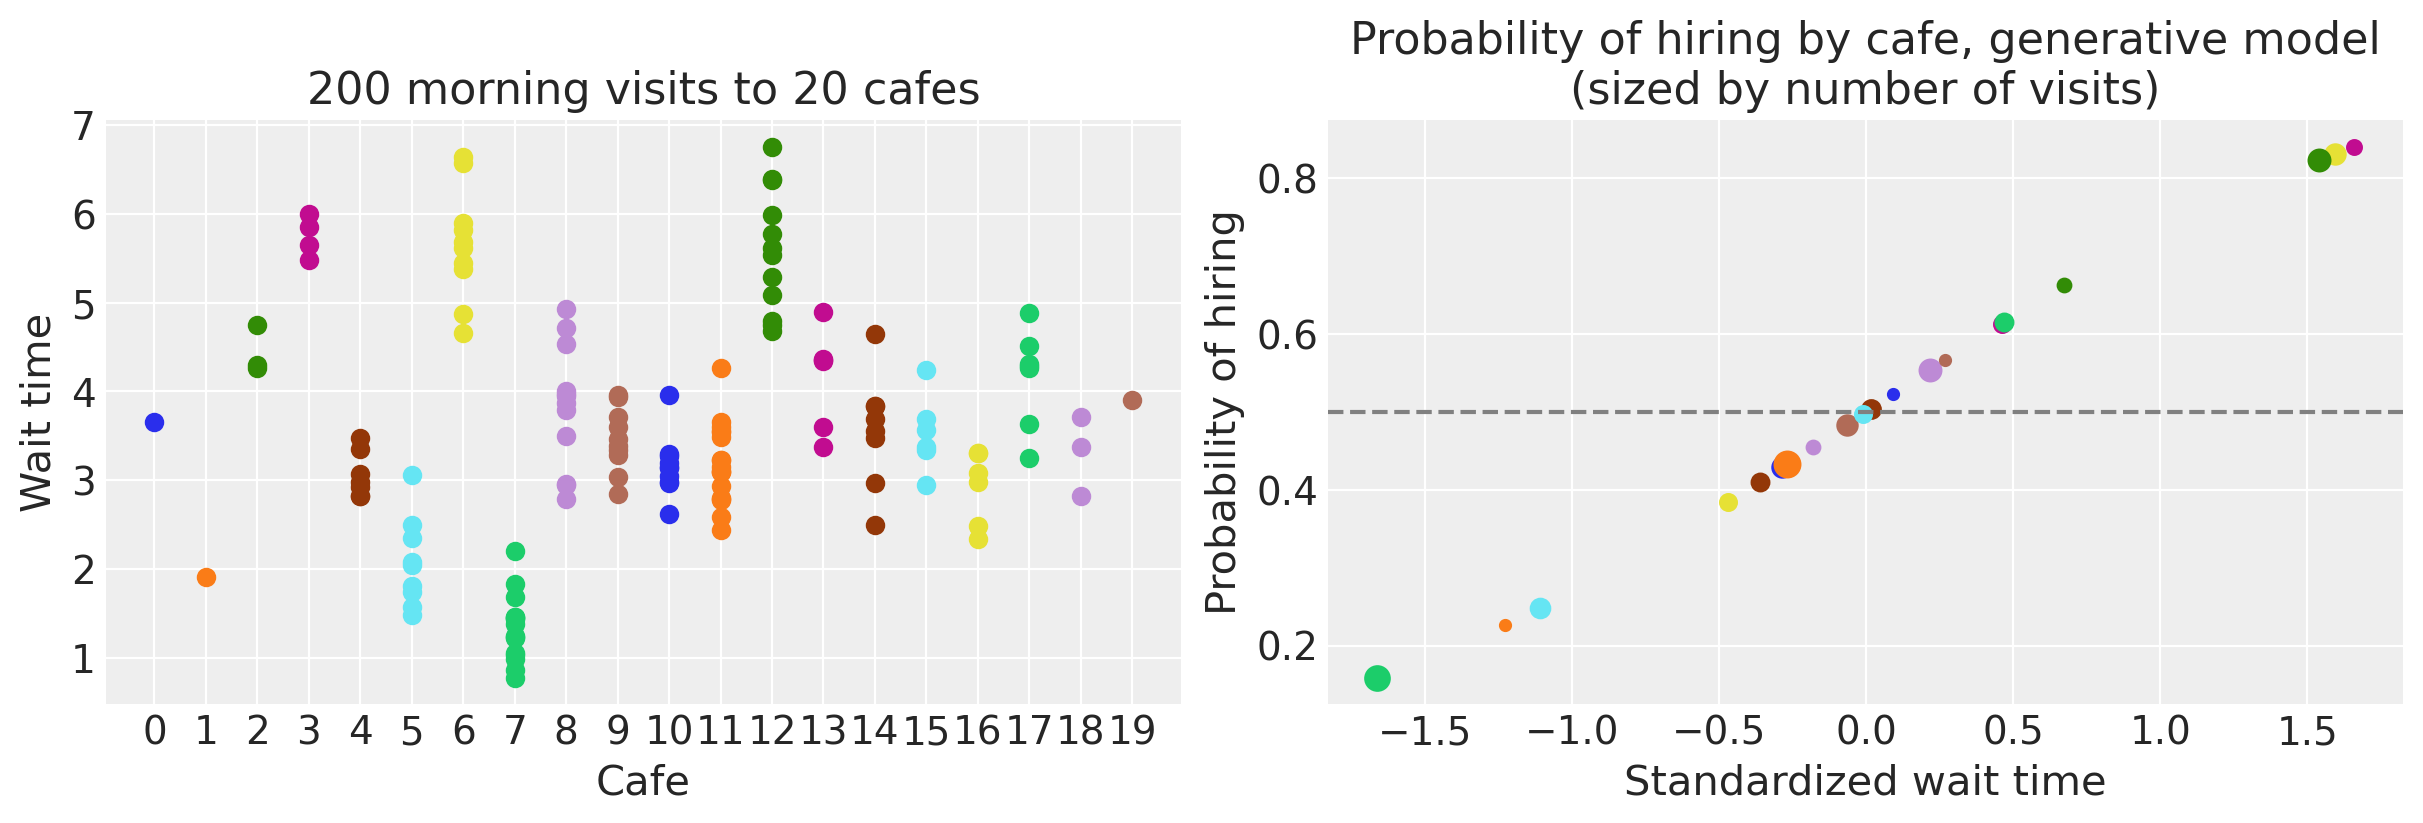

<IPython.core.display.Javascript object>

In [13]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,4))
# plot a different color for each cafe
for cafe in range(N_cafe):
    df_cafe = df_cafes[df_cafes['cafe'] == cafe].copy()
    ax0.scatter(df_cafe['cafe'], df_cafe['wait'])
    df_cafe_summary = df_cafes_summary[df_cafes_summary['cafe'] == cafe].copy()
    ax1.scatter(df_cafe_summary['wait_time_std'], df_cafe_summary['prob_hire'], s=10 + 4*df_cafe_summary['n_visits'])
    
ax0.set(xlabel='Cafe', ylabel='Wait time', title='200 morning visits to 20 cafes')
ax0.set_xticks(range(N_cafe))
ax0.set_xticklabels(range(N_cafe));

ax1.axhline(0.5, color='gray', linestyle='--')
ax1.set(xlabel='Standardized wait time', ylabel='Probability of hiring', title='Probability of hiring by cafe, generative model\n(sized by number of visits)');

**Do I actually want to see if I need to hire on each observation?**

Another way that we can generate data, however, is to use all of the uncertainty of a prior and generate prior predictive simulations. This means that instead of assigning an arbitrary value for $\bar{\alpha}$ and $\sigma_{\alpha}$, we would draw samples from their respective distributions.

In [54]:
# # These arbitrary values were taken from SR Chapter 14

# N_cafe = 20                              # number of cafes

# # Generate distributions for each cafe
# n = 10**4                                # number of draws from the sample distribution
# a_cafes_dist = np.zeros((N_cafe, n))     # initialize an array to hold the distributions

# for i in range(N_cafe):
#     sigma_a = stats.expon.rvs(scale=1/1, size=1)    # scipy.stats.exp uses lambda as scale = 1/lambda
#     a_bar = stats.norm.rvs(loc=0, scale=1.5, size=1)
#     a_cafes_dist[i, :] = stats.norm.rvs(loc=a_bar, scale=sigma_a, size=n)
    
# print(f"shape of array: {a_cafes_dist.shape}")

<IPython.core.display.Javascript object>

In [55]:
# pd.DataFrame(
#     {"means of each cafe" : np.mean(a_cafes_dist, axis=1),
#     "SD of each cafe" : np.std(a_cafes_dist, axis=1),
#     "89% HDI of each cafe" : [np.around(az.hdi(a_cafes_dist[i, :]), 3) for i in range(N_cafe)]}
# )

<IPython.core.display.Javascript object>

### Co-varying intercepts and slopes

Here we'll demonstrate varying slopes as a different kind of varying effects. Here, we'll be showing how the intercepts and slopes can be correlated, although the use of a multivariate normal distribution can apply to other scenarios (i.e. additional features) where we have an implicit correlation structure. Rather than have one term that exhibits partial pooling we now have two. Furthermore, those two variables have an implied covariance. Our covariance will be between the $\bar{\alpha}$ and $\bar{\beta}$ terms, represented in code by `a_bar` and `b_bar`, respectively. By expressing this covariance in a multivariate normal distribution, we can enable partial pooling between these parameters. This increases the accuracy of estimates in a statistical model than if partial pooling for those variables were separate. Here is the multi-variate normal equation again.

$$ \begin{bmatrix}\alpha_j \\ \beta_j \end{bmatrix} \sim \text{MVNormal} \left( \begin{bmatrix}\bar{\alpha} \\ \bar{\beta} \end{bmatrix} , \bold{\Sigma} \right) $$

As we did in the varying intercepts model, let's generate data with these assumptions before running a statistical model. We'll input arbitrary values.

In [10]:
N_cafe = 20         # number of cafes
a_bar = 3.5  # average morning wait time
b_bar = -1.0  # average difference afternoon wait time
sigma_a = 1.0  # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7  # correlation between intercepts and slopes

# assemble the mean vector
Mu = np.array([a_bar, b_bar])
# assemble the covariance matrix
Sigma = np.array([[sigma_a**2, rho*sigma_a*sigma_b],
                    [rho*sigma_a*sigma_b, sigma_b**2]])
            
# Generate samples for each cafe
mu_ve_dist = stats.multivariate_normal.rvs(mean=Mu, cov=Sigma, size=N_cafe)
mu_ve_dist

array([[ 4.62180182, -1.2613978 ],
       [ 3.1138486 , -0.19863321],
       [ 3.9464575 , -0.98022922],
       [ 3.76847651, -1.88389192],
       [ 2.38853076, -0.7146377 ],
       [ 2.87812486, -1.29073156],
       [ 0.57996694,  0.36872469],
       [ 3.07150103, -1.34038853],
       [ 3.00298804, -0.71934255],
       [ 4.83710976, -1.17140018],
       [ 2.90024074, -1.03082108],
       [ 4.23716554, -1.31469605],
       [ 2.06388637, -0.46309215],
       [ 4.30592732, -1.30457247],
       [ 3.82310446, -0.91116513],
       [ 4.28809184, -1.06609928],
       [ 3.81388506, -0.95322764],
       [ 6.68078525, -1.76674401],
       [ 1.95022524, -0.50833079],
       [ 3.09328394, -0.68435143]])

<IPython.core.display.Javascript object>

This time, each draw from our sample distribution (representing each hypothetical cafe) contains two values, the mean wait time and the coefficient for wait time when we are looking at the afternoon ($A=1$). When we take the inverse logit of the afternoon wait time, we can think of our data now as the probability of a cafe hiring another worker for the afternoon shift.

In [20]:
pm_wait_time = mu_ve_dist[:, 0] + mu_ve_dist[:, 1]
wait_time_pm_std = standardize(pm_wait_time)
prob_pm_hire = expit(wait_time_pm_std)

df_cafes_pm = pd.DataFrame(
    {
        "wait_time_raw_pm": pm_wait_time,
        "wait_time_pm_std": wait_time_pm_std,
        "prob_pm_hire": prob_pm_hire,
    }
)

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'Standardized wait time'),
 Text(0, 0.5, 'Probability of hiring\n(pm shift)'),
 Text(0.5, 1.0, 'Probability of hiring by cafe\n(afternoon shift)')]

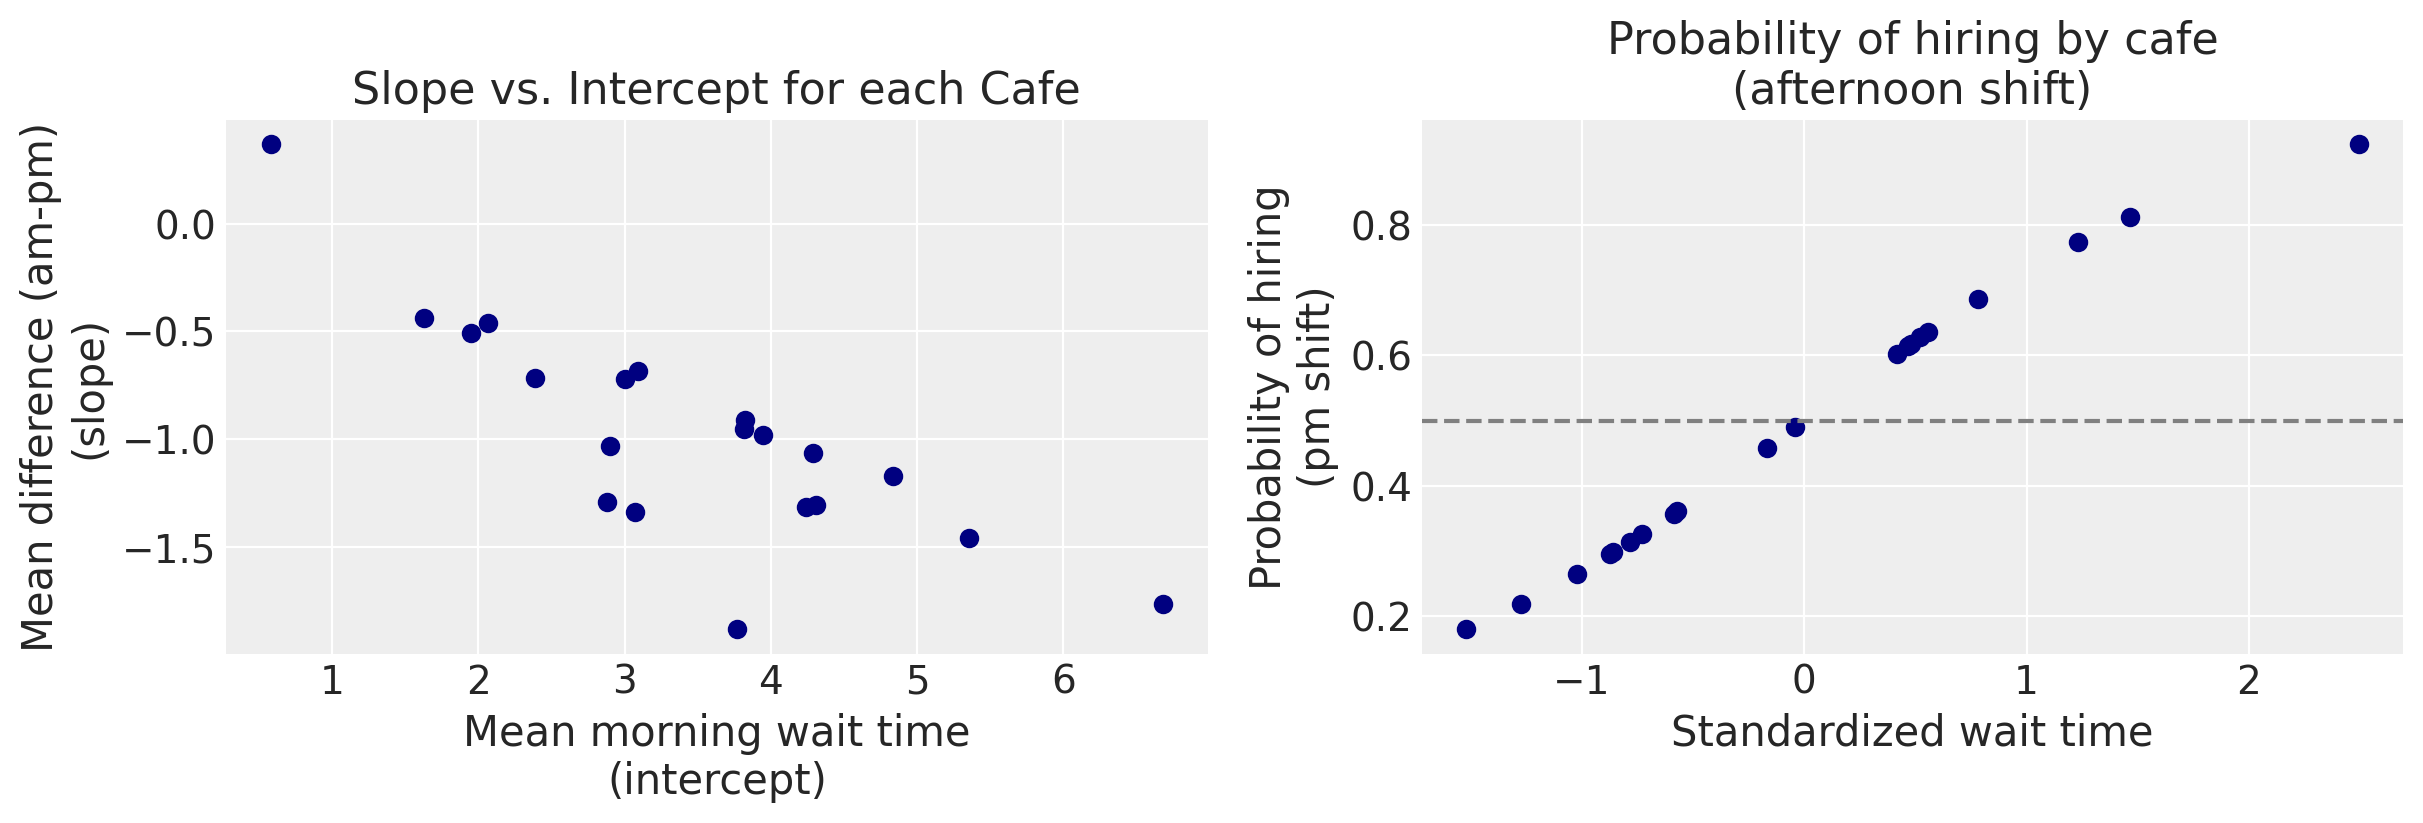

<IPython.core.display.Javascript object>

In [21]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,4))
ax0.scatter(mu_ve_dist[:, 0], mu_ve_dist[:, 1], c='navy')
ax0.set(xlabel='Mean morning wait time\n(intercept)', ylabel='Mean difference (am-pm)\n(slope)', title='Slope vs. Intercept for each Cafe')

ax1.scatter( df_cafes_pm['wait_time_pm_std'], df_cafes_pm['prob_pm_hire'], color='navy')
ax1.axhline(0.5, color='gray', linestyle='--')
ax1.set(xlabel='Standardized wait time', ylabel='Probability of hiring\n(pm shift)', title='Probability of hiring by cafe\n(afternoon shift)')

## Inferential model

Now that we've generated the data, let's see if we can correctly build models that recover the parameters. We'll still think in terms of centered paramaterizations here and look at both the varying intercepts and varying effects examples.

We can look directly at the equations side-by-side to see how the parameters between varying intercepts and varying effects compare.

<center>

**Centered paramaterization**  

|  | varying intercepts | varying effects|
| -- | -- | -- | 
| likelihood | $ H_i \sim \text{Bernoulli}(p_i) $  | $ H_i \sim \text{Bernoulli}(p_i) $  |
| linear model | $ \text{logit}(p_i) = \alpha_{\text{cafe}[i]} $  | $ \text{logit}(p_i) = \alpha_{\text{cafe}[i]} + \beta_{\text{cafe}[i]}A_i $  |
| adaptive prior for each cafe | $ \alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma_{\alpha}) $  | $ \begin{bmatrix}\alpha_j \\ \beta_j \end{bmatrix} \sim \text{MVNormal} \left( \begin{bmatrix}\bar{\alpha} \\ \bar{\beta} \end{bmatrix} , \bold{\Sigma} \right)  $  | 
| hyperprior for average cafe | $ \bar{\alpha} \sim \text{Normal}(0, 1.5) $  | $ \bar{\alpha}, \bar{\beta} \sim \text{Normal}(0, 1.5) $   |
| hyperprior for SD of cafe | $ \sigma_{\alpha} \sim \text{Exp}(1) $  | $ \sigma_{\alpha}, \sigma_{\beta} \sim \text{Exp}(1) $   |
| hyperprior for correlation matrix | n/a | $ \text{LKJCorr}(2) $   |


</center>

### Varying intercepts

In [86]:
df_cafes.head()

,cafe,wait,wait_time_std,prob_hire,cafe_hire
0,0,4.601115,0.515819,0.626169,True
1,0,3.383384,-0.336271,0.416716,False
2,1,2.962304,-0.630916,0.347303,False
3,2,4.751320,0.620922,0.650428,True
4,2,3.867494,0.002478,0.500620,True


<IPython.core.display.Javascript object>

In [59]:
df_cafes_summary.head()

,cafe,wait,wait_time_std,prob_hire,cafe_hire,n_visits
0,0,4.607353,1.800662,0.858230,True,1
1,1,2.856856,-0.943123,0.280270,False,1
2,2,3.502564,0.068981,0.517238,True,3
3,3,3.183936,-0.430447,0.394019,False,4
4,4,4.217319,1.189311,0.766618,True,7


<IPython.core.display.Javascript object>

In [93]:
with pm.Model() as mVIc:

    # prior for average cafe wait time
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    # prior for SD of cafe wait time
    sigma_a = pm.Exponential("sigma", 1.0)

    # alpha priors for each cafe wait time
    a = pm.Normal("a", a_bar, sigma_a, shape=N_cafe)

    # link function
    p = pm.Deterministic("p", pm.math.invlogit(a[df_cafes['wait_time_std']]))

    # likelihood, n=1 since each represents an individual cafe visit
    h = pm.Bernoulli("h", p=p, observed=df_cafes["cafe_hire"])

    trace_mVIc = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
INFO:pymc3:NUTS: [a, sigma, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


<IPython.core.display.Javascript object>

In [94]:
az.summary(trace_mVIc, var_names=['a_bar', 'sigma', 'a'])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.596,0.776,-1.914,0.556,0.013,0.011,3508.0,2710.0,3512.0,3041.0,1.0
sigma,3.565,0.883,2.124,4.820,0.026,0.018,1193.0,1193.0,1212.0,1870.0,1.0
a[0],-0.131,1.484,-2.359,2.324,0.023,0.024,4206.0,1856.0,4250.0,2623.0,1.0
a[1],-2.907,2.906,-7.159,1.647,0.057,0.053,2578.0,1530.0,3414.0,1921.0,1.0
a[2],3.562,2.240,0.397,6.878,0.053,0.045,1812.0,1213.0,2590.0,1472.0,1.0
a[3],4.061,2.054,1.037,6.991,0.044,0.036,2145.0,1673.0,2777.0,1821.0,1.0
a[4],-2.002,1.133,-3.713,-0.248,0.017,0.015,4372.0,3028.0,4961.0,2733.0,1.0
a[5],-4.666,2.213,-7.912,-1.576,0.044,0.034,2574.0,2137.0,3244.0,2386.0,1.0
a[6],4.812,1.997,1.924,7.537,0.048,0.038,1727.0,1409.0,2352.0,1622.0,1.0
a[7],-5.154,2.130,-7.973,-1.964,0.050,0.040,1836.0,1426.0,2535.0,1715.0,1.0


<IPython.core.display.Javascript object>

Yikes. This didn't sample well at all. But this will help us illustrate the point that non-centered parameterizations can do better.

# Non-centered paramaterization


<center>

**Centered paramaterization**  

|  | varying intercepts | varying effects|
| -- | -- | -- | 
| likelihood | $ H_i \sim \text{Bernoulli}(p_i) $  | $ H_i \sim \text{Bernoulli}(p_i) $  |
| linear model | $ \text{logit}(p_i) = \alpha_{\text{cafe}[i]} $  | $ \text{logit}(p_i) = \alpha_{\text{cafe}[i]} + \beta_{\text{cafe}[i]}A_i $  |
| adaptive prior for each cafe | $ \alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma_{\alpha}) $  | $ \begin{bmatrix}\alpha_j \\ \beta_j \end{bmatrix} \sim \text{MVNormal} \left( \begin{bmatrix}\bar{\alpha} \\ \bar{\beta} \end{bmatrix} , \bold{\Sigma} \right)  $  | 
| hyperprior for average cafe | $ \bar{\alpha} \sim \text{Normal}(0, 1.5) $  | $ \bar{\alpha}, \bar{\beta} \sim \text{Normal}(0, 1.5) $   |
| hyperprior for SD of cafe | $ \sigma_{\alpha} \sim \text{Exp}(1) $  | $ \sigma_{\alpha}, \sigma_{\beta} \sim \text{Exp}(1) $   |
| hyperprior for correlation matrix | n/a | $ \text{LKJCorr}(2) $   |

<br>
<br>

**Non-centered paramaterization**  

|  | varying intercepts | varying effects|
| -- | -- | -- | 
| likelihood | $ H_i \sim \text{Bernoulli}(p_i) $  | $ H_i \sim \text{Bernoulli}(p_i) $  |
| linear model | $ \text{logit}(p_i) = \alpha_{\text{cafe}[i]} $  | $ \text{logit}(p_i) = \alpha_{\text{cafe}[i]} + \beta_{\text{cafe}[i]}A_i $  |
| adaptive prior (deterministic) | $ \alpha_j = \bar{\alpha} + z \times \sigma_{\alpha} $  | $ \begin{bmatrix}\alpha_j \\ \beta_j \end{bmatrix} \sim \text{MVNormal} \left( \begin{bmatrix}\bar{\alpha} \\ \bar{\beta} \end{bmatrix} , \bold{\Sigma} \right)  $  | 
| random variable | $ z_j \sim \text{Normal}(0, 1) $  | $ \begin{bmatrix}\alpha_j \\ \beta_j \end{bmatrix} \sim \text{MVNormal} \left( \begin{bmatrix}\bar{\alpha} \\ \bar{\beta} \end{bmatrix} , \bold{\Sigma} \right)  $  | 
| hyperprior for average cafe | $ \bar{\alpha} \sim \text{Normal}(0, 1.5) $  | $ \bar{\alpha}, \bar{\beta} \sim \text{Normal}(0, 1.5) $   |
| hyperprior for SD of cafe | $ \sigma_{\alpha} \sim \text{Exp}(1) $  | $ \sigma_{\alpha}, \sigma_{\beta} \sim \text{Exp}(1) $   |
| hyperprior for correlation matrix | n/a | $ \text{LKJCorr}(2) $   |



</center>


$$ \alpha_j = \bar{\alpha} + z \times \sigma_{\alpha} $$ 
$$ \bar{\alpha} \sim \text{Normal}(0, 1.5) $$
$$ z \sim \text{Normal}(0, 1) $$
$$ \sigma \sim \text{Exponential}(1) $$

In [91]:
df_cafes

,cafe,wait,wait_time_std,prob_hire,cafe_hire
0,0,4.601115,0.515819,0.626169,True
1,0,3.383384,-0.336271,0.416716,False
2,1,2.962304,-0.630916,0.347303,False
3,2,4.751320,0.620922,0.650428,True
4,2,3.867494,0.002478,0.500620,True
...,...,...,...,...,...
195,18,3.181316,-0.477665,0.382804,False
196,18,3.029178,-0.584122,0.357985,False
197,19,3.324161,-0.377711,0.406679,False
198,19,4.351214,0.340954,0.584422,True


<IPython.core.display.Javascript object>

In [95]:
with pm.Model() as mVInc:

    # prior for average cafe wait time
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    # prior for SD of cafe wait time
    # sigma_a = pm.Exponential("sigma", 1.0)
    sigma_a = pm.Exponential("sigma", 1.0)
    
    # random variable to improve sampling
    z = pm.Normal("z", 0.0, 1.0, shape=N_cafe)

    # a results from a deterministic relationship
    a = pm.Deterministic("a", a_bar + z * sigma_a)

    # link function
    p = pm.Deterministic("p", pm.math.invlogit(a[df_cafes['cafe']]))

    # likelihood, n=1 since each represents an individual cafe visit
    h = pm.Bernoulli("h", p=p, observed=df_cafes["cafe_hire"])

    trace_mVInc = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, sigma, a_bar]
INFO:pymc3:NUTS: [z, sigma, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


<IPython.core.display.Javascript object>

In [97]:
df_summary_mVInc = az.summary(trace_mVInc, var_names=['a'])
df_summary_mVInc

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.126,1.555,-2.565,2.373,0.023,0.026,4556.0,1765.0,4603.0,2824.0,1.0
a[1],-2.880,2.706,-7.138,1.095,0.055,0.046,2424.0,1732.0,2791.0,2098.0,1.0
a[2],3.498,2.159,0.361,6.624,0.046,0.038,2202.0,1607.0,2890.0,1813.0,1.0
a[3],4.025,2.058,0.982,6.965,0.041,0.034,2504.0,1788.0,3291.0,2066.0,1.0
a[4],-2.001,1.143,-3.662,-0.235,0.019,0.016,3789.0,2663.0,4463.0,2547.0,1.0
a[5],-4.620,2.256,-7.695,-1.333,0.046,0.036,2376.0,1936.0,3155.0,2085.0,1.0
a[6],4.799,1.979,1.855,7.362,0.039,0.031,2557.0,2056.0,3390.0,2332.0,1.0
a[7],-5.078,2.169,-8.039,-2.033,0.042,0.034,2605.0,2057.0,3499.0,2282.0,1.0
a[8],0.831,0.604,-0.148,1.781,0.008,0.006,5939.0,4428.0,5942.0,3469.0,1.0
a[9],-0.491,0.505,-1.298,0.294,0.007,0.006,4626.0,3733.0,4521.0,3480.0,1.0


<IPython.core.display.Javascript object>

This sampled much better. Let's look at our estimates.

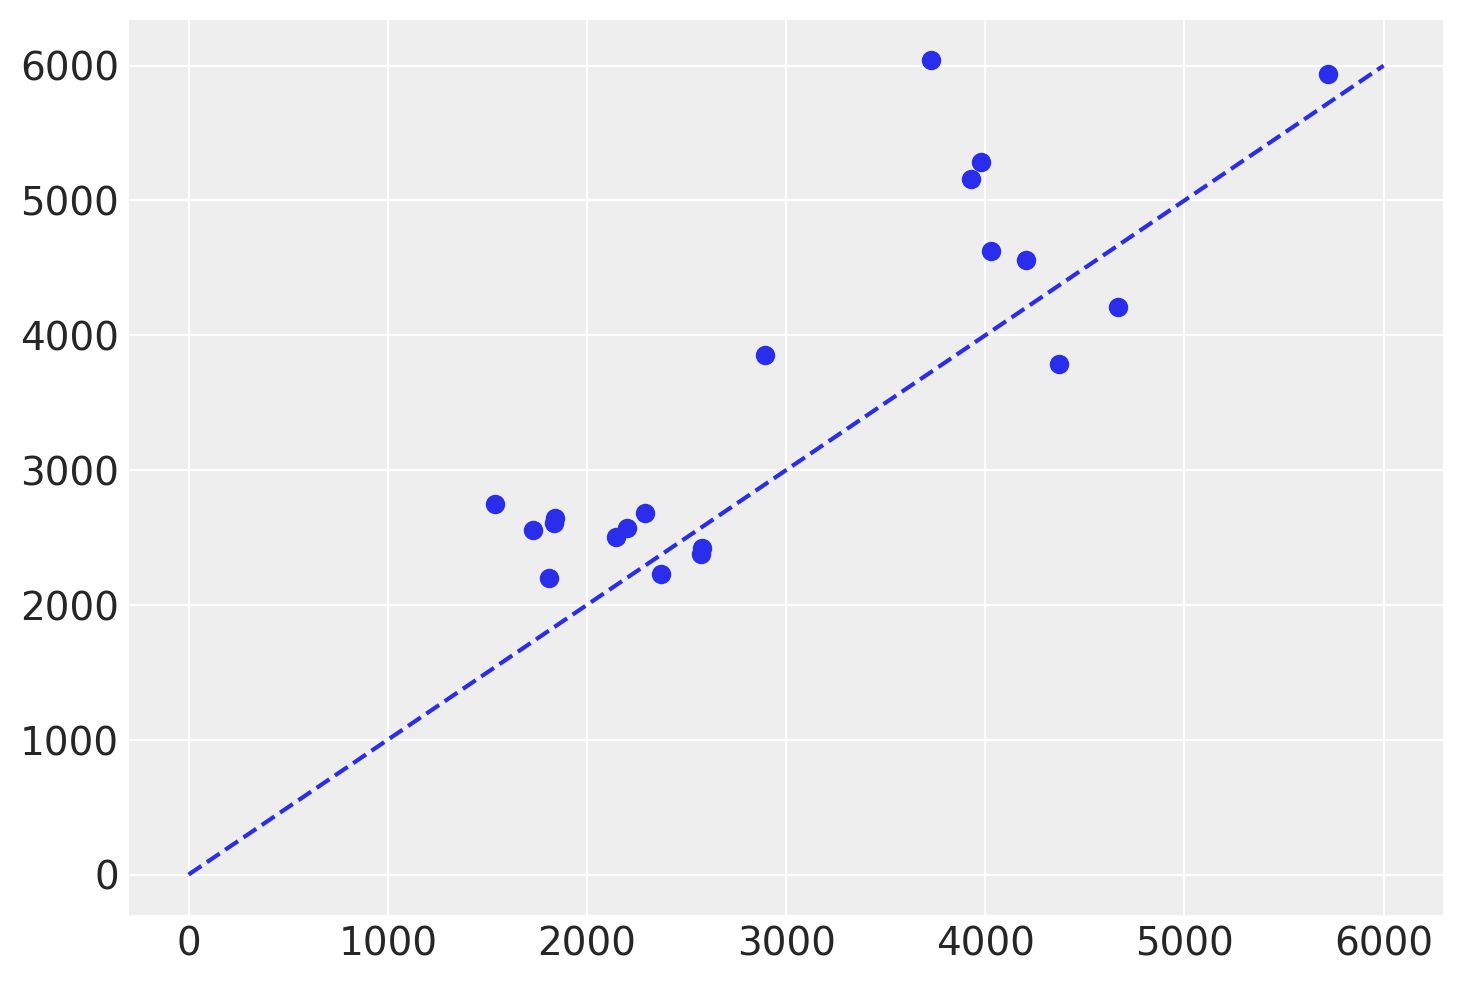

<IPython.core.display.Javascript object>

In [100]:
plt.scatter(az.summary(trace_mVIc, var_names=['a'])['ess_mean'], az.summary(trace_mVInc, var_names=['a'])['ess_mean'])
plt.plot([0, 6000], [0, 6000], '--')

In [93]:
df_summary_mVInc['mean']

a[0]    -0.893
a[1]    -0.932
a[2]    -0.903
a[3]     0.541
a[4]     0.533
a[5]    -0.885
a[6]     0.506
a[7]     0.572
a[8]     0.477
a[9]    -0.897
a[10]    0.454
a[11]   -0.884
a[12]    0.535
a[13]   -0.900
a[14]   -0.904
a[15]    0.500
a[16]    0.560
a[17]   -0.902
a[18]   -0.896
a[19]   -0.902
Name: mean, dtype: float64

<IPython.core.display.Javascript object>

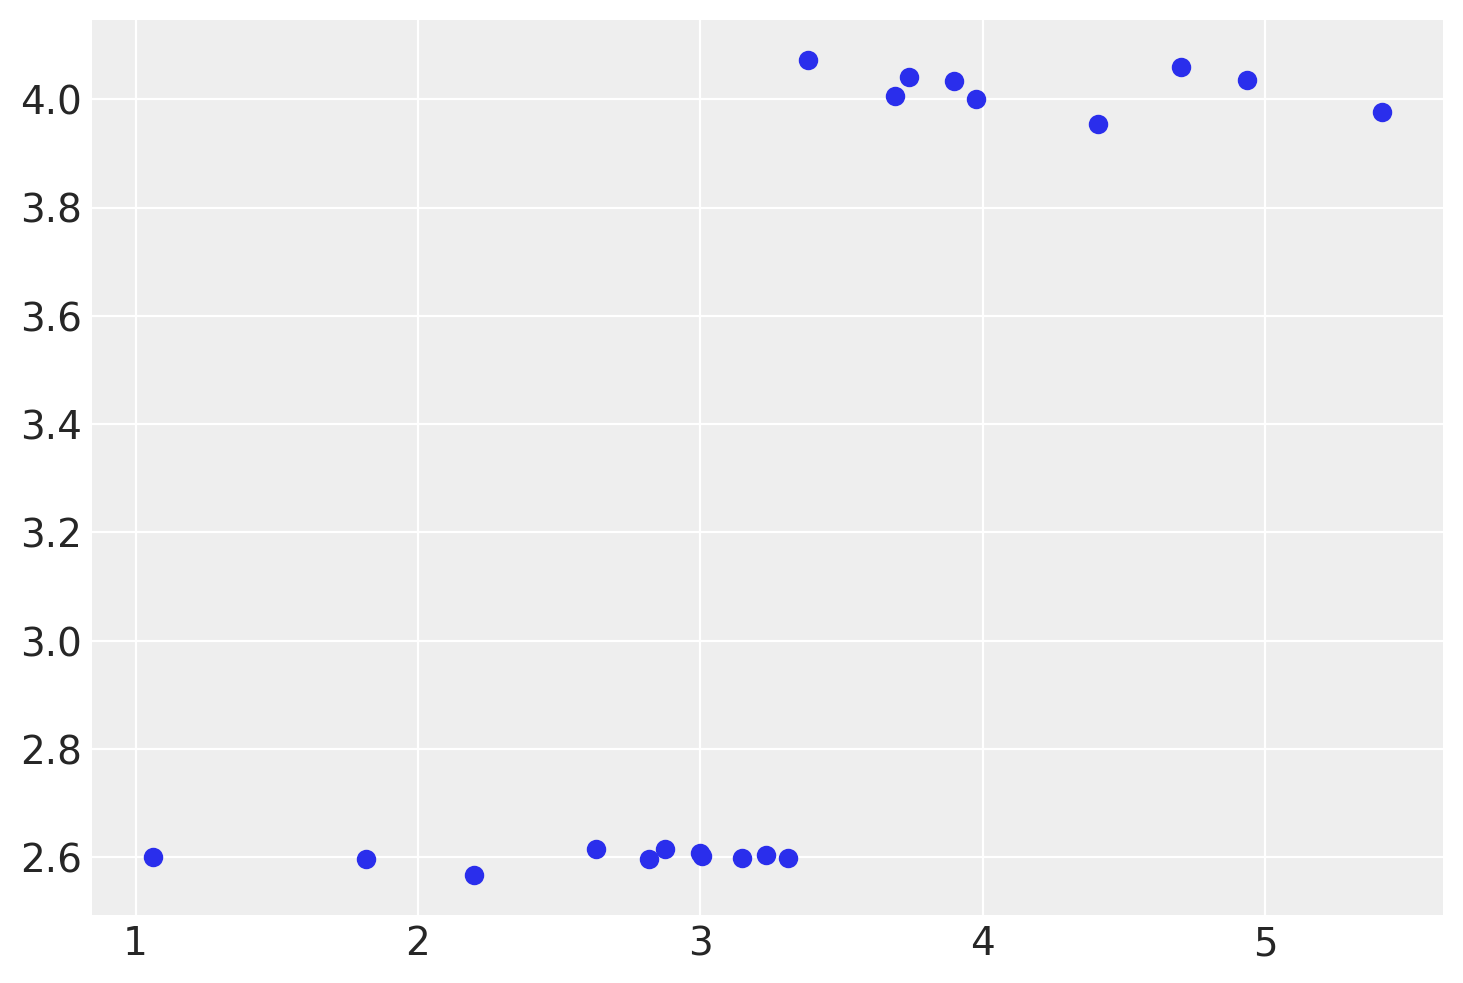

<IPython.core.display.Javascript object>

In [103]:
f, ax0 = plt.subplots()
ax0.scatter(df_cafes['wait_time_raw'], (df_summary_mVInc['mean'] * sigma_a) + a_bar)

In [100]:
(a-abar)/sd = (astd * sd) + abar

SyntaxError: cannot assign to operator (<ipython-input-100-698da1420548>, line 1)

<IPython.core.display.Javascript object>

In [101]:
(df_cafes['wait_time_std'] * sigma_a) + a_bar

0     3.144671
1     2.364025
2     2.966955
3     3.867209
4     4.023644
5     2.784211
6     3.821069
7     3.518674
8     5.506180
9     3.150718
10    4.521975
11    3.024070
12    5.039953
13    1.251633
14    1.988164
15    4.102035
16    4.811235
17    3.449196
18    3.375170
19    3.289214
Name: wait_time_std, dtype: float64

<IPython.core.display.Javascript object>

In [98]:
sigma_a = 1.0  # std dev in intercepts
a_bar = 3.5  

<IPython.core.display.Javascript object>

In [99]:
a_bar

3.5

<IPython.core.display.Javascript object>

# Appendix

In [45]:
%watermark -n -u -v -iv -w

Last updated: Sat Apr 02 2022

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

matplotlib: 3.3.4
pandas    : 1.2.1
arviz     : 0.11.1
sys       : 3.8.6 | packaged by conda-forge | (default, Jan 25 2021, 23:22:12) 
[Clang 11.0.1 ]
scipy     : 1.6.0
seaborn   : 0.11.1
numpy     : 1.20.1
theano    : 1.1.0
pymc3     : 3.11.0

Watermark: 2.1.0



<IPython.core.display.Javascript object>